In [31]:
import pandas as pd
import numpy as np
from plotnine import *
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

player_db = pd.read_csv('tow_processed.csv')

# Warhammer: The Old World
## A Statistical Analysis of Tournament Win Rates
### By: Jacob M. Lundeen

I was first introduced to Games Workshop's (GW) Warhammer: Fantasy Battles (WFB) back in the mid 1990's in Fairfax, Virginia. I was in the fifth or sixth grade and wondered by a GW store with my parents. I convinced them to take me in and managed to walk out with my first eight pack of skeleton warriors (Undead for life!). Over the next couple of years I would acquire a healthy collection of miniatures that was significantly boosted by my winning a White Dwarf survey contest and bringing home $5k worth of Tyranids, Dogs of War, Blood Bowl, and a others. As I grew up, I lost interest in WFB for various reasons as a lot of kids do. However, with WFB being reborn as Warhammer: The Old World (TOW) earlier this year, and me as an adult able to afford this hobby, I jumped back in and haven't looked back.

Since I've rediscovered TOW, I've wanted to combine TOW with one of my other passions, Data Science. With TOW only having returned earlier this year, the available data set is still immature. As we'll see there are many instances of incredible small sample sizes when we look at specific faction versus faction. But my hope is this will give an interesting look into where the game currently stands, where it might need to go, and lead to other interesting questions to ask and explore.

## The Data
The data I am using comes from the Woehammer website (woehammer.com). They compiled their dataset by scraping several tournament tracking websites such as Best Coast Pairings (bestcoastpairings.com). Tournaments use these websites to manage and track the results of their tournaments. The dataset contains a lot of data for each game played. For this analysis, however, I won't be using it all. The following fields will be used for this notebook:
* player_faction: the army used by the player
* player_subfaction: the army subfaction used by the player (note: currently only three armies have subfactions)
* opponent_faction: the army used by the opponent
* opponent_subfaction: the army subfaction used by the opponent (note: currently only three armies have subfactions)
* result: the result of the game from the perspective of the player. 1.0 = win, 0.0 = loss, 0.5 = tie
* points: the point size of the armies in the game
* rounds: the number of rounds of the tournament (one, three, or five)
* ruleset: the ruleset under which the game was played. GW puts out Frequently Asked Questions (FAQ) updates to clarify the game rules
* players: the number of players that participated in the tournament in which that game was played 

One major caveat that needs we must keep in mind with these analyses is that the analysis is skewed. It is skewed because this data comes from tournaments played around the world and those tournaments, more often then not, introduce additional rules and restrictions beyond what GW has currently published. For example, many tournaments utilize a rule called the "Rule of Three" meaning that an army cannot contain more than three characters. There are many other rules that tournaments employ to create "fairness" or eliminate a combination that abuses a standard rule. Because of these additional restrictions and because the data does not identify whether a tournament utilized additional restrictions or not, we cannot conduct an analysis without this skew present. 

### Extract, Transform, Load
The original dataset provided by Woehammer required some transformation to get it into a workable form. All strings were made lowercase and all whitespace/special characters were removed. Faction names were shortened for readability on visualizations. The subfaction variable was present in the original dataset but was all NaN values. Since the dataset contains the actual muster list for each army I was able to search the lists and identify any subfactions that were used. All mirror matches and any match were the primary data for either player was missing were removed.

In [7]:
player_db.shape

(3232, 9)

In [8]:
player_db.head()

,player_faction,player_subfaction,opponent_faction,opponent_subfaction,result,points,rounds,ruleset,players
0,w_chaos,grand army,wood_elves,grand army,0.0,2000,3,v1.1,12
1,tomb_kings,grand army,high_elves,grand army,1.0,2000,3,v1.1,12
2,bretonnia,exiles,dwarves,grand army,0.0,2000,3,v1.1,12
3,ogres,grand army,dwarves,grand army,1.0,2000,3,v1.1,12
4,wood_elves,grand army,tomb_kings,grand army,1.0,2000,3,v1.1,12


We have 3232 samples with 9 variables.

## Analysis
### Faction Win Rate
We will start our analysis by looking at the win rate by faction without considering any other variable like point size or tournament length. This will give us a comparison to use when we start controlling for those other variables.

In [10]:
tow_faction_wr = player_db.groupby(['player_faction'])['opponent_faction'].count().reset_index()
wins_db = player_db.query("result != 0.0").groupby(['player_faction'])['result'].sum().reset_index()
tow_faction_wr['wins'] = wins_db['result']
tow_faction_wr.rename(columns={'opponent_faction':'games_played'}, inplace=True)
tow_faction_wr['win_rate'] = tow_faction_wr['wins'] / tow_faction_wr['games_played']
tow_faction_wr['points'] = 'all'
tow_faction_wr = tow_faction_wr[list(('player_faction', 'points', 'games_played', 'wins', 'win_rate'))]
tow_faction_wr

,player_faction,points,games_played,wins,win_rate
0,beastmen,all,163,85.0,0.521472
1,bretonnia,all,378,206.0,0.544974
2,chaos_dwarves,all,59,29.0,0.491525
3,d_chaos,all,89,42.0,0.471910
4,dark_elves,all,137,63.0,0.459854
5,dwarves,all,258,115.5,0.447674
6,empire,all,240,92.0,0.383333
7,high_elves,all,222,120.0,0.540541
8,lizardmen,all,84,37.5,0.446429
9,o_and_g,all,320,164.0,0.512500


So what do we see here: four factions have less than one hundred games played and every faction has at least twenty-nine wins. Four factions have over three hundred games played. Of the sixteen factions, five have win rates outside the accepted "sweet spot" of 45-55%, all of which are under 45%.

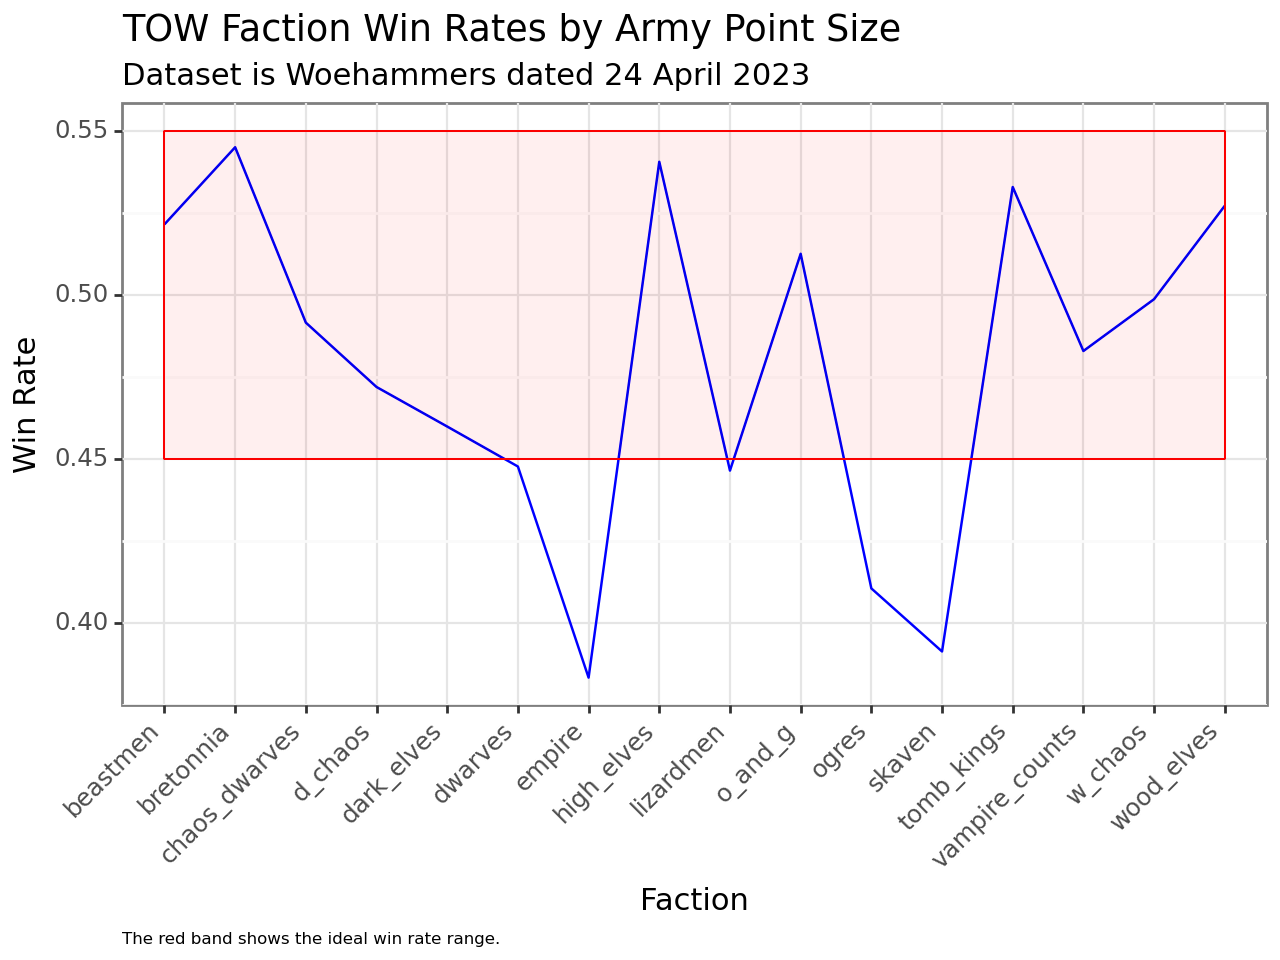

<Figure Size: (640 x 480)>

In [59]:
(
    ggplot(tow_faction_wr, aes(x='player_faction', y='win_rate', group='points', color='points'))
    + geom_line()
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=6), legend_position="none")
    + labs(title='TOW Faction Win Rates by Army Point Size', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Points Size', caption="The red band shows the ideal win rate range.")
    + scale_color_manual(values=['blue'])
)

The line chart gives a nice visualization of what the data told us, all but four of the factions fall within the accepted win rate range.

Now it is time to build a model and see what insights we can get. Normally we would do an Ordinary Least Squares (OLS) linear regression, but since we have less than twenty data points, and we are working with count data, we will instead use a Poisson Regression. The Poisson model will allow us to offset the wins by the games played since the number of games played have a wide range.

In [51]:
X = tow_faction_wr['player_faction']
X = pd.get_dummies(X, columns=['player_faction'], dtype=int, prefix_sep='', prefix='')
y = tow_faction_wr['wins']
feature_names = X.columns.to_list()

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
model = sm.GLM(y, exog, family=sm.families.Poisson(), offset=tow_faction_wr['games_played']).fit()
model.summary()

C:\ProgramData\Anaconda3\envs\Project\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
C:\ProgramData\Anaconda3\envs\Project\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wins   No. Observations:                   16
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49.988
Date:                Wed, 26 Jun 2024   Deviance:                  -3.9857e-14
Time:                        15:01:51   Pearson chi2:                 2.71e-22
No. Iterations:                     5   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -197.5919      0.031  -6476.800      0.000    -197.652    -197.532
x1             9.4488      0.026    368.434      0.000       9.398       9.499
x2           -42.3802      0.017  -2433.010      0.000     -42.414     -42.346
x3            34.3629      0.043    804.936      0.000      34.279      34.447
x4            27.1907      0.036    761.420      0.000      27.121      27.261
x5            15.6699      0.029    531.767      0.000      15.612      15.728
x6           -13.4729      0.022   -603.475      0.000     -13.517     -13.429
x7            -9.1708      0.025   -370.765      0.000      -9.219      -9.122
x8            -4.7494      0.022   -216.378      0.000      -4.792      -4.706
x9            28.3735      0.038    752.499      0.000      28.300      28.447
x10          -28.3958      0.019  -1481.939      0.000     -28.433     -28.358
x11           25.7204      0.037    695.110      0.000      25.648      25.793
x12           26.4272      0.038    687.246      0.000      26.352      26.503
x13          -35.6265      0.018  -1962.848      0.000     -35.662     -35.591
x14           13.5185      0.028    483.495      0.000      13.464      13.573
x15          -42.4017      0.018  -2346.536      0.000     -42.437     -42.366
x16           -4.5145      0.022   -202.990      0.000      -4.558      -4.471
==============================================================================
"""

### Win Rate by Points
The next analysis is going to look at win rates when point sizes are accounted for. Games can be played at any pre-determined army size, but the standard army size is 2000 points. I will include all point sizes in the model, but we can look at the most popular point sizes first to get an idea of what the model might tell us.

In [11]:
player_db.groupby(['points'])['player_faction'].count().sort_values(ascending=False).reset_index()

,points,player_faction
0,2000,1672
1,1500,836
2,1250,334
3,1999,128
4,1000,110
5,1750,106
6,2500,30
7,2250,10
8,500,6


We see the three most popular point sizes are 2000, 1500, and 1250. So now we need to transform our dataset, so we can perform the statistical analysis. We've already calculated the win rate by faction for all point sizes, so we just need to calculate the win rate by point size and then join the two datasets on player_faction and points.

In [12]:
tow_points_wr = player_db.groupby(['player_faction', 'points'])['opponent_faction'].count().reset_index()
tow_points_wins = player_db.query("result != 0.0").groupby(['player_faction', 'points'])['result'].sum().reset_index()
tow_points_wr = tow_points_wr.merge(tow_points_wins, left_on=['player_faction', 'points'], right_on=['player_faction', 'points'], how='left')
tow_points_wr.rename(columns={'opponent_faction':'games_played', 'result':'wins'}, inplace=True)
tow_points_wr['win_rate'] = tow_points_wr['wins'] / tow_points_wr['games_played']
tow_points_wr = pd.concat([tow_points_wr, tow_faction_wr], ignore_index=True).sort_values(by=['player_faction', 'points']).dropna().reset_index(drop=True)
tow_points_wr['points'] = tow_points_wr['points'].astype(str)
tow_points_wr

,player_faction,points,games_played,wins,win_rate
0,beastmen,1250,16,8.0,0.500000
1,beastmen,1500,49,18.5,0.377551
2,beastmen,1750,14,8.5,0.607143
3,beastmen,1999,2,1.0,0.500000
4,beastmen,2000,82,49.0,0.597561
...,...,...,...,...,...
110,wood_elves,1750,7,4.5,0.642857
111,wood_elves,1999,11,4.5,0.409091
112,wood_elves,2000,111,57.0,0.513514
113,wood_elves,2250,2,2.0,1.000000


We will start by plotting the win rates of the top three point sizes (with the faction's overall win rate as a reference) and see what patterns we might be able to discern.

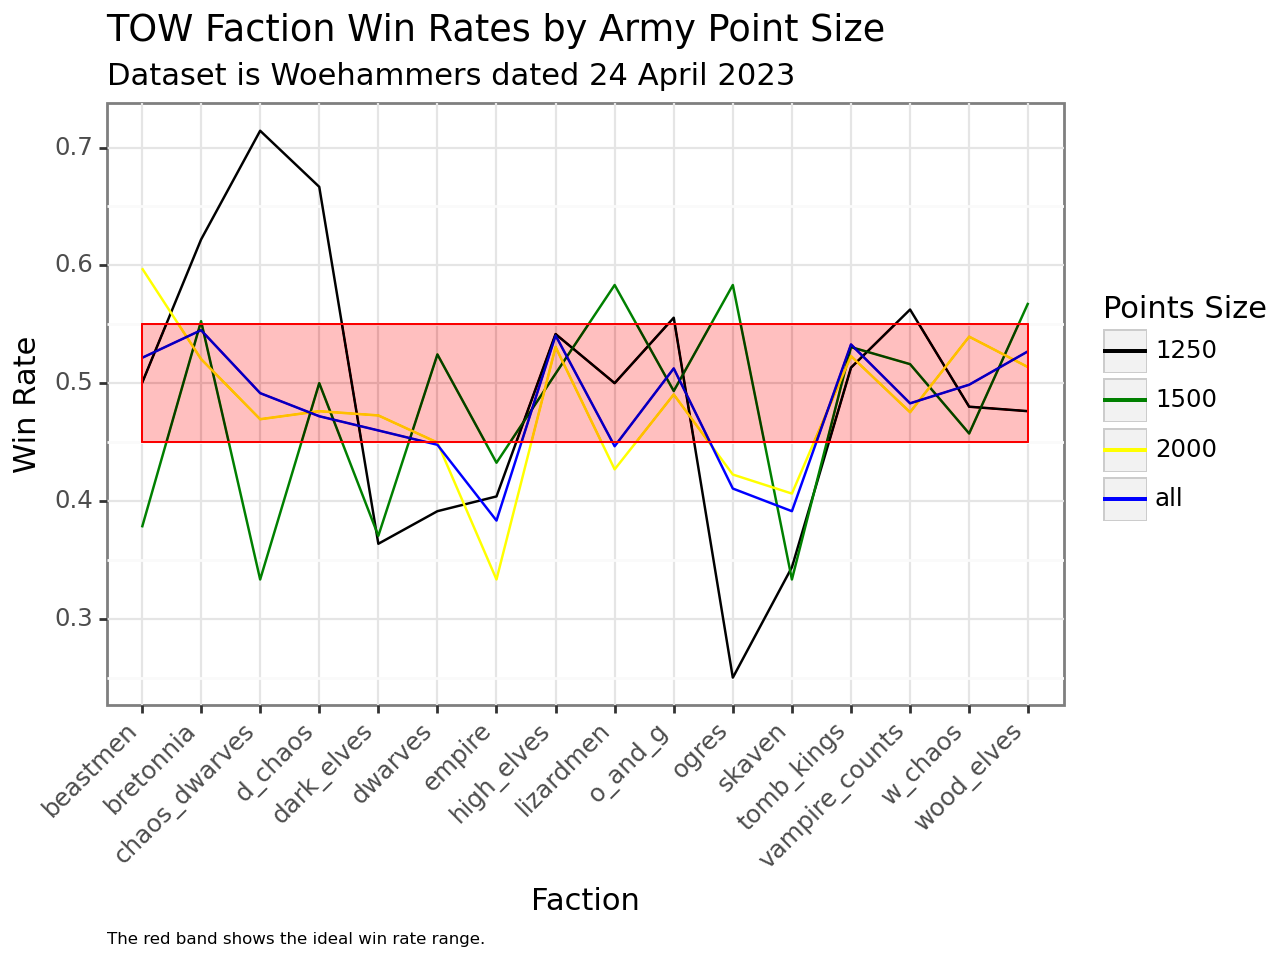

<Figure Size: (640 x 480)>

In [55]:
filter_list = ['all', '2000', '1500', '1250']
tow_plot = tow_points_wr.query("points == @filter_list")
(
    ggplot(tow_plot, aes(x='player_faction', y='win_rate', group='points', color='points'))
    + geom_line()
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=6))
    + labs(title='TOW Faction Win Rates by Army Point Size', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Points Size', caption="The red band shows the ideal win rate range.")
    + scale_color_manual(values=['black', 'green', 'yellow', 'blue'])
)

So some initial observation: the 2000 points line follows our baseline pretty closely. This makes sense as the 2000 point size makes up the bulk of the dataset. The 1500 and 1250 point sizes show a lot of variance, especially with the Chaos Dwarves and Ogres. The Empire, High Elves, Orcs & Goblins, Skaven, Tomb Kings, Vampire Counts, and Warriors of Chaos all look to be very consistent.

Now we can move into the regression analysis. We will use Ordinary Least Squares from the statsmodel package. This package will handle creating dummy variables for any categorical variable. 

In [14]:
formula = 'win_rate ~ player_faction + points'
model_df = tow_points_wr.query("points != 'all'")
mod = smf.ols(formula, model_df).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     1.497
Date:                Fri, 21 Jun 2024   Prob (F-statistic):             0.0984
Time:                        11:31:26   Log-Likelihood:                 57.972
No. Observations:                  99   AIC:                            -67.94
Df Residuals:                      75   BIC:                            -5.662
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.5623      0.085      6.620      0.000       0.393       0.731
player_faction[T.bretonnia]          0.0151      0.090      0.167      0.868      -0.164       0.195
player_faction[T.chaos_dwarves]     -0.0126      0.114     -0.110      0.912      -0.240       0.215
player_faction[T.d_chaos]           -0.0638      0.099     -0.646      0.521      -0.261       0.133
player_faction[T.dark_elves]        -0.0132      0.090     -0.147      0.884      -0.192       0.166
player_faction[T.dwarves]           -0.1493      0.094     -1.587      0.117      -0.337       0.038
player_faction[T.empire]            -0.0569      0.093     -0.612      0.543      -0.242       0.128
player_faction[T.high_elves]         0.0725      0.092      0.792      0.431      -0.110       0.255
player_faction[T.lizardmen]         -0.0474      0.095     -0.498      0.620      -0.237       0.142
player_faction[T.o_and_g]            0.0243      0.094      0.258      0.797      -0.163       0.212
player_faction[T.ogres]             -0.0820      0.098     -0.837      0.405      -0.277       0.113
player_faction[T.skaven]            -0.1779      0.100     -1.774      0.080      -0.378       0.022
player_faction[T.tomb_kings]         0.0412      0.092      0.450      0.654      -0.141       0.224
player_faction[T.vampire_counts]    -0.0151      0.094     -0.161      0.873      -0.203       0.172
player_faction[T.w_chaos]           -0.0989      0.090     -1.103      0.274      -0.278       0.080
player_faction[T.wood_elves]         0.0036      0.092      0.039      0.969      -0.179       0.186
points[T.1250]                      -0.0345      0.060     -0.574      0.568      -0.154       0.085
points[T.1500]                      -0.0483      0.060     -0.803      0.424      -0.168       0.071
points[T.1750]                      -0.0461      0.066     -0.699      0.487      -0.177       0.085
points[T.1999]                      -0.0510      0.061     -0.842      0.403      -0.172       0.070
points[T.2000]                      -0.0493      0.060     -0.821      0.414      -0.169       0.070
points[T.2250]                       0.2111      0.093      2.276      0.026       0.026       0.396
points[T.2500]                       0.0540      0.079      0.680      0.499      -0.104       0.212
points[T.500]                        0.1776      0.107      1.666      0.100      -0.035       0.390
==============================================================================
Omnibus:                        5.932   Durbin-Watson:                   2.423
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                6.547
Skew:                           0.335   Prob(JB):                       0.0379
Kurtosis:                       4.066   

The OLS model is not significant (Probability of F-statistic >= 0.05) and is not predictive (Adjusted R-Squared). There is only one statistically significant variable (points[T.2250]) but that only has ten samples.

We can run an Analysis of Variance (ANOVA) to see if player_faction and/or points are significant.

In [15]:
table = sm.stats.anova_lm(mod, typ=2)
table

,sum_sq,df,F,PR(>F)
player_faction,0.408199,15.0,1.135817,0.340985
points,0.372747,8.0,1.944697,0.065506
Residual,1.796941,75.0,NaN,NaN


The ANOVA is showing that neither of our variables are statistically significant. With the model not being signficant or predictive, there is no need for a pairwise test so we can move onto the next analysis.

### Win Rate by Rounds

So now we will do the same analysis as before, but this time looking at the faction win rates when controlling for the number of rounds during a tournament. The prevailing belief is that three-day tournaments (or five rounds) is where the top level players show through. So we want to see if the win rate during five-round tournaments are statistically different from the overall win rates.

In [17]:
player_db.groupby(['rounds'])['player_faction'].count().sort_values(ascending=False).reset_index()

,rounds,player_faction
0,3,2416
1,5,788
2,1,28


So there are three levels of tournament rounds: one, three, and five. We have more than triple the samples of three-round compared to five-round and not even thirty samples of one-round tournaments.

In [18]:
tow_rounds_wr = player_db.groupby(['player_faction', 'rounds'])['opponent_faction'].count().reset_index()
tow_rounds_wins = player_db.query("result != 0.0").groupby(['player_faction', 'rounds'])['result'].sum().reset_index()
tow_rounds_wr = tow_rounds_wr.merge(tow_rounds_wins, left_on=['player_faction', 'rounds'], right_on=['player_faction', 'rounds'], how='left')
tow_rounds_wr.rename(columns={'opponent_faction':'games_played', 'result':'wins'}, inplace=True)
tow_rounds_wr['win_rate'] = tow_rounds_wr['wins'] / tow_rounds_wr['games_played']
tow_rounds_wr = (pd.concat([tow_rounds_wr, tow_faction_wr.rename(columns={'points':'rounds'})], ignore_index=True).sort_values(by=['player_faction', 'rounds']).
                 dropna().reset_index(drop=True))
tow_rounds_wr['rounds'] = tow_rounds_wr['rounds'].astype(str)
tow_rounds_wr

,player_faction,rounds,games_played,wins,win_rate
0,beastmen,1,2,0.0,0.000000
1,beastmen,3,94,49.5,0.526596
2,beastmen,5,67,35.5,0.529851
3,beastmen,all,163,85.0,0.521472
4,bretonnia,1,4,0.0,0.000000
...,...,...,...,...,...
57,w_chaos,all,378,188.5,0.498677
58,wood_elves,1,1,0.0,0.000000
59,wood_elves,3,156,85.0,0.544872
60,wood_elves,5,64,31.5,0.492188


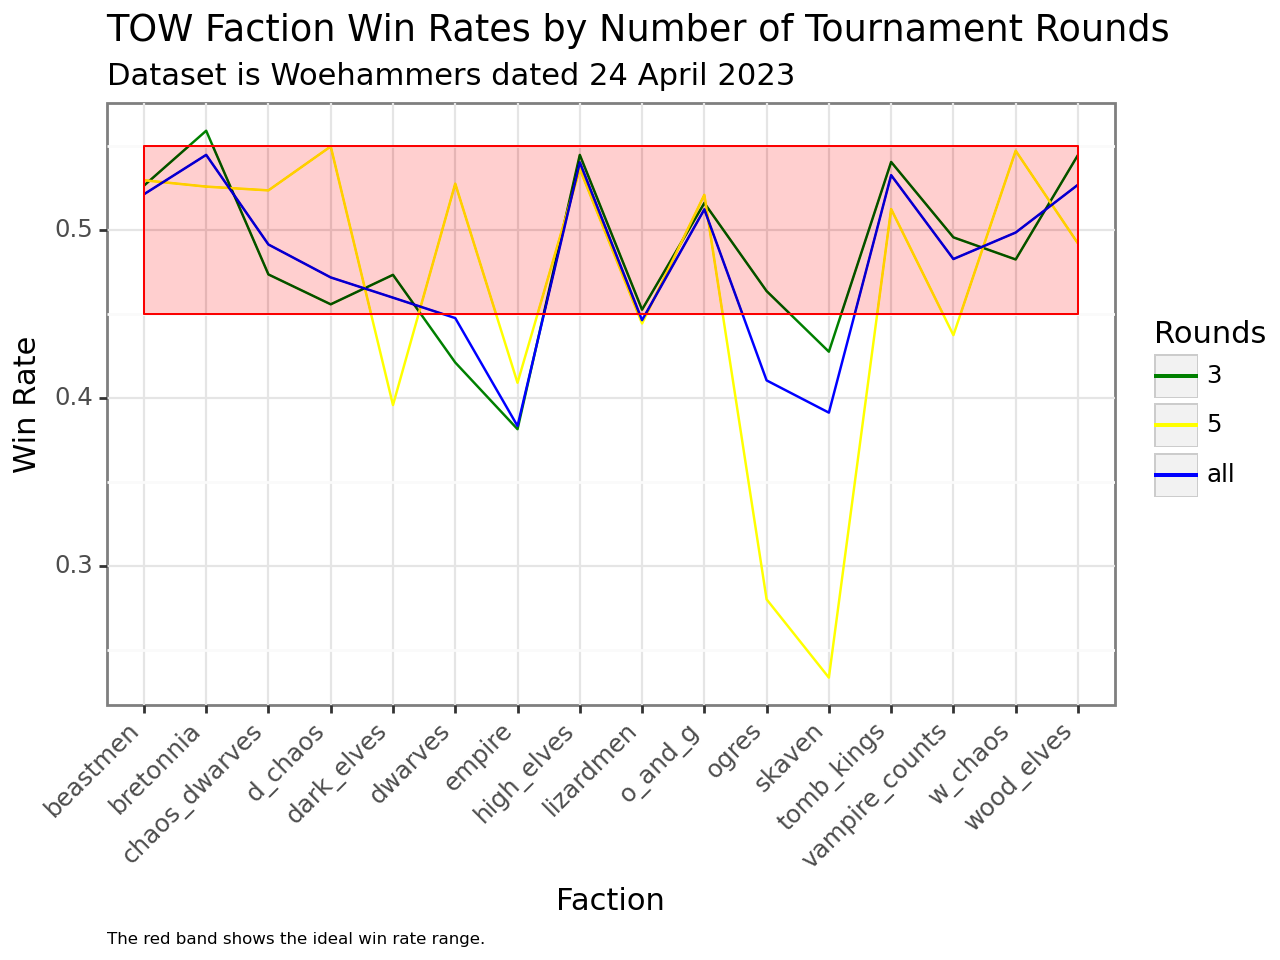

<Figure Size: (640 x 480)>

In [60]:
(
    ggplot(tow_rounds_wr.query("rounds != '1'"), aes(x='player_faction', y='win_rate', group='rounds', color='rounds'))
    + geom_line()
    + geom_rect(aes(xmin=1,xmax=16,ymin=0.45,ymax=0.55),color="red", fill="red", alpha=0.005, size=0.1)
    + theme_bw()
    + theme(axis_text_x = element_text(angle=45, hjust=1), plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}, size=6))
    + labs(title='TOW Faction Win Rates by Number of Tournament Rounds', subtitle='Dataset is Woehammers dated 24 April 2023', x='Faction', y='Win Rate', color='Rounds', caption="The red band shows the ideal win rate range.")
    + scale_color_manual(values=['green', 'yellow', 'blue'])
)

The chart is remarkably similar to the previous chart when controlling for points. We can see factions like Bretonnia, High Elves, and Tomb Kings all having similar win rates. So let's build a model and see what we have.

In [24]:
rounds_formula = 'win_rate ~ player_faction + rounds'
rounds_model = smf.ols(rounds_formula, tow_rounds_wr.query("rounds != '1' and rounds != 'all'")).fit()
rounds_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     2.177
Date:                Fri, 21 Jun 2024   Prob (F-statistic):             0.0699
Time:                        12:34:59   Log-Likelihood:                 56.730
No. Observations:                  32   AIC:                            -79.46
Df Residuals:                      15   BIC:                            -54.54
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.5374      0.044     12.282      0.000       0.444       0.631
player_faction[T.bretonnia]          0.0145      0.060      0.241      0.813      -0.113       0.142
player_faction[T.chaos_dwarves]     -0.0295      0.060     -0.491      0.631      -0.157       0.098
player_faction[T.d_chaos]           -0.0253      0.060     -0.421      0.680      -0.153       0.103
player_faction[T.dark_elves]        -0.0936      0.060     -1.559      0.140      -0.222       0.034
player_faction[T.dwarves]           -0.0537      0.060     -0.895      0.385      -0.182       0.074
player_faction[T.empire]            -0.1330      0.060     -2.215      0.043      -0.261      -0.005
player_faction[T.high_elves]         0.0125      0.060      0.209      0.837      -0.115       0.140
player_faction[T.lizardmen]         -0.0796      0.060     -1.327      0.204      -0.208       0.048
player_faction[T.o_and_g]           -0.0095      0.060     -0.159      0.876      -0.137       0.118
player_faction[T.ogres]             -0.1563      0.060     -2.604      0.020      -0.284      -0.028
player_faction[T.skaven]            -0.1977      0.060     -3.294      0.005      -0.326      -0.070
player_faction[T.tomb_kings]        -0.0015      0.060     -0.025      0.980      -0.129       0.126
player_faction[T.vampire_counts]    -0.0616      0.060     -1.026      0.321      -0.190       0.066
player_faction[T.w_chaos]           -0.0132      0.060     -0.220      0.829      -0.141       0.115
player_faction[T.wood_elves]        -0.0097      0.060     -0.161      0.874      -0.138       0.118
rounds[T.5]                         -0.0183      0.021     -0.864      0.401      -0.064       0.027
==============================================================================
Omnibus:                        0.272   Durbin-Watson:                   3.178
Prob(Omnibus):                  0.873   Jarque-Bera (JB):                0.000
Skew:                           0.000   Prob(JB):                         1.00
Kurtosis:                       3.015   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model is both a strong fit (R-squared close to 1.0), statistically significant (Prob(F-statistic) <= 0.5), and predictive (Adjust R-squared close to 1.0). We have three variables (Empire, Ogres, and Skaven) that are significant with negative coefficients which aligns with their win rates being less than 45%.

In [25]:
rounds_table = sm.stats.anova_lm(rounds_model, typ=2)
rounds_table

,sum_sq,df,F,PR(>F)
player_faction,0.122847,15.0,2.27267,0.061449
rounds,0.002688,1.0,0.74597,0.401355
Residual,0.054054,15.0,NaN,NaN


The ANOVA confirms that both player_faction and rounds are significant. Lastly, the pairwise test.

In [26]:
rounds_pw = rounds_model.t_test_pairwise("rounds")
rounds_pw.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
5-3,-0.018331,0.021224,-0.863695,0.401355,-0.063568,0.026907,0.401355,False


The pairwise test shows that there is a statistically significant difference between five-round tournament win rates and all win rates.

## Summary

So the two main takeways from this analysis are:
* The point size of an army has no significant effect on the armies overall win rate
* There is a statistically significant difference between the win rates of armies depending on the length of a tournament.

This second observation is of particular interest. While there is a difference, it is slight and either in favor of total win rate or the three round tournaments. This would imply that it is, in fact, more difficult to win during a five-round tournament. However, it affects most factions equally. The only factions that were significant in the regression model were Empire, Skaven, and Ogres, all with negative coefficients which holds the theme that those three factions continually underperformed.

## Future Work

My intent is to keep up this work as Woehammer releases their updated datasets to see how/if the trends change over time. I intend to also look at the win rates by FAQ/Errata releases. My long term goal is to parse the actual army lists (if possible) and conduct a comparison analysis to see which units are most frequently used and which units are most valuable.